##LAB2: END-TO-END MACHINE LEARNING PROJECT
###“FACE DETECTION APPLICATION”
##Eya Rayes, Mohamed Ibrahim Abouda: 3DNI2

## 1/ Feature Engineering

In [ ]:
from time import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images

### Q1 – How many positives samples are in positive_patches?

In [ ]:
print(len(positive_patches))

13233


### Q2 – Show some positive samples (e.g., 16) 

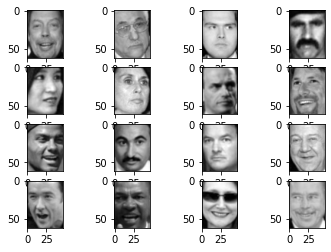

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(positive_patches[i,:,:],cmap='gray')

### Q3 – Try the Scikit-Image’s HOG extractor and visualize the oriented gradients for a given sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc978bbae90>,
 <matplotlib.image.AxesImage at 0x7fc978cacd90>)

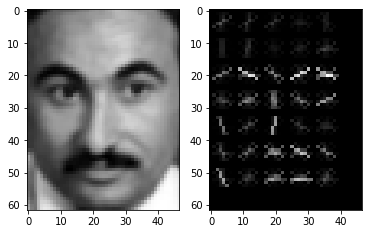

In [ ]:
from skimage import color, feature
import skimage.data
sample=positive_patches[9]
img = color.rgb2gray(sample) #choose a sample here!
hog_vec, hog_vis = feature.hog(img, visualize=True)

plt.subplot(1,2,1),plt.imshow(sample,cmap="gray")
plt.subplot(1,2,2),plt.imshow(hog_vis,cmap="gray")

##Set of negative samples

In [ ]:
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
  extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
  extractor = PatchExtractor(patch_size=extracted_patch_size,max_patches=N, random_state=0)
  patches = extractor.transform(img[np.newaxis])
  if scale != 1:
    patches = np.array([transform.resize(patch, patch_size) for patch in patches])
  return patches

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


In [ ]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])

###Q4 – How many negative samples are in negative_patches?

In [ ]:
print(len(negative_patches))

30000


###Q5 – Show some negative samples (e.g., 16) (plt.subplot() and plt.imhsow())

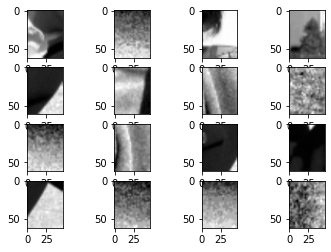

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(negative_patches[i,:,:],cmap='gray')

#

#Q6 – Combine negative and positive sets (same number of samples in each set) and extract their HOG features to get data set X of size [n_samples, n_features].

In [ ]:
import pandas as pd
type(positive_patches)
combine= np.concatenate([positive_patches, negative_patches])
combine.shape

(43233, 62, 47)

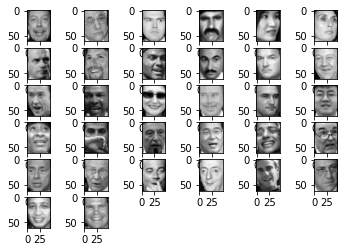

In [ ]:
for i in range(32):
  plt.subplot(6,6,i+1)
  plt.imshow(combine[i,:,:], cmap='gray')

In [ ]:
N=min(positive_patches.shape[0],negative_patches.shape[0])
print(N)

13233


#Q7 – Construct vector of labels y: 0 for all negative samples and 1 for all positive samples.

In [ ]:
n=min(positive_patches.shape[0],negative_patches.shape[0])
dim=hog_vec.shape[0]
X=np.zeros((2*n,dim))
Y=np.concatenate((np.ones((n,1)),np.zeros((n,1))), axis=0)
for i in range(n):
  img=positive_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec=feature.hog(img_gray)
  X[i,:]=hog_vec.reshape(1,dim)
for i in range(n):
  img=negative_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec=feature.hog(img_gray)
  X[i+n,:]=hog_vec.reshape(1,dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if sys.path[0] == '':


In [ ]:
print(X.shape)
print(Y.shape)

(26466, 1215)
(26466, 1)


In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data

print(X.shape, Y.shape) 
concate = np.concatenate((X,Y),axis=1)
data = asarray(concate)
# save to csv file
savetxt('data_face.csv', data, delimiter=',')

(26466, 1215) (26466, 1)


#2/ Binary Classification using Scikit-Learn

In [ ]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# View the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21172, 1215), (5294, 1215), (21172, 1), (5294, 1))

We build different binary classifiers with the best estimator for each 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
models = [
{ "estimater": KNeighborsClassifier(),
"params": {
"n_neighbors": [25],
"weights": ['uniform'],
"leaf_size": [25],
"p": [1],
}
},
{ "estimater": DecisionTreeClassifier(),
"params": {
"criterion": ['gini'],
"splitter": ['best'],
"max_depth": [None],
"max_features": [None],
"random_state": [42]
}
},
{ "estimater": svm.SVC(),
"params": {
    'C': [0.1], 'gamma': [1], 'kernel': ['rbf']
}
},
{ "estimater": RandomForestClassifier(),
"params": {
"criterion": ['gini'],
"bootstrap": [True, False],
"max_depth": [85],
"max_features": ['sqrt'],
"n_estimators": [60],
"random_state": [42]
}
}
]
column_names = ["KNeighbors", "DecisionTree", "SVM", "RF"]
entries = []
max_acc = 0
best_model = None
print(X_train.shape, y_train.shape)
for model in models:
  print(model["estimater"])
# Create model
  clf = model["estimater"]
# Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf, param_grid = model["params"], cv = 5)
# Fit the model
  grid_search.fit(X_train, y_train.ravel())
  print("griiid search")
# Make predictions on the test set compute accuracy metric
  predicted = grid_search.predict(X_test)
  acc = accuracy_score(predicted, y_test)
  entries.append(acc)
  print(grid_search.best_params_)
# Get the best model with the highest accuracy
  if acc > max_acc:
    max_acc = acc
    best_model = grid_search

(21172, 1215) (21172, 1)
KNeighborsClassifier()
griiid search
{'leaf_size': 25, 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
DecisionTreeClassifier()
griiid search
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'random_state': 42, 'splitter': 'best'}
SVC()
griiid search
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
RandomForestClassifier()
griiid search
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 85, 'max_features': 'sqrt', 'n_estimators': 60, 'random_state': 42}


We plot each model **performance**

      Estimator  Accuracy
0    KNeighbors  0.997167
1  DecisionTree  0.936154
2           SVM  0.533245
3            RF  0.989800


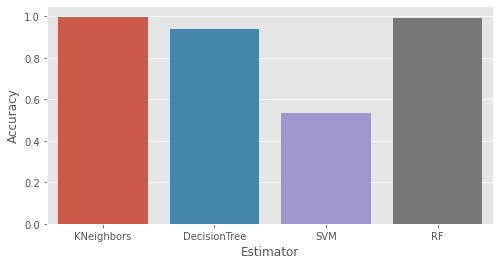

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
df = pd.DataFrame({"Estimator": column_names, "Accuracy": entries})
plt.figure(figsize=(8, 4))
sns.barplot(x='Estimator', y='Accuracy', data=df)
print(df)

##Q8: Test the above scripts and write in a markdown cell your conclusions
Les échantillons appartiennent à deux classes ou plus et nous voulons apprendre à partir de données déjà étiquetées comment prédire la classe de données non étiquetées. scikit-learn est livré avec quelques ensembles de données standard.

## 3/ Evaluating the Best Face Detector


*First, we create an evaluation function to output all the needs metrics:*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):

  accuracy = accuracy_score(y_true, y_preds)
  precision = precision_score(y_true, y_preds, average='micro')
  recall = recall_score(y_true, y_preds, average='micro')
  f1 = f1_score(y_true, y_preds, average='micro')
  metric_dict = {"accuracy": round(accuracy, 2),
  "precision": round(precision, 2),
  "recall": round(recall, 2),
  "f1": round(f1, 2)}
  return metric_dict

###Q9: Make predictions using the test data to see how the best model performs by applying the evaluate_preds function.

In [ ]:
y_pred= best_model.predict(X_test)
ev = evaluate_preds(y_test,y_pred)
print(ev)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


## 4/ Finding Faces in a New Image

*We run a sliding window over a new image and evaluate each patch*


###Q10: Get a new test image by executing this script:

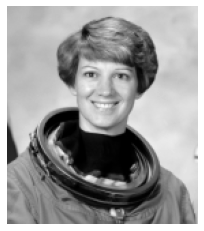

In [ ]:
test_image= skimage.data.astronaut()
test_image=skimage.color.rgb2gray(test_image)
test_image=skimage.transform.rescale(test_image, 0.5)
test_image=test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

###Q11 : Create a window that iterates over patches of this image, and compute HOG features for each patch:

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,istep=2, jstep=2, scale=1.0):
  Ni, Nj = (int(scale * s) for s in patch_size)
  for i in range(0, img.shape[0] - Ni, istep):
    for j in range(0, img.shape[1] - Ni, jstep):
      patch = img[i:i + Ni, j:j + Nj]
      if scale != 1:
        patch = transform.resize(patch, patch_size)
      yield (i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])

###Q12 : Use our face detector to evaluate whether each patch contains a face. What do you notice?

In [ ]:
labels = best_model.predict(patches_hog)
labels.sum()

140.0

##Q13- Draw face detected patches as rectangles:  

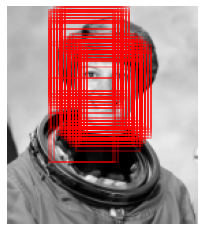

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=0.3, lw=2, facecolor='none'))

#Q14. Model Deployment with Python and Streamlit

In [ ]:
print(best_model)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [25], 'n_neighbors': [25], 'p': [1],
                         'weights': ['uniform']})
